In [1]:
# Configuración inicial
import sys
sys.path.append('..')

import torch
import matplotlib.pyplot as plt
import random

from src.dataset import get_dataloaders
from src.models import CustomCNN, get_resnet18
from src.train import train_model
from src.evaluate import evaluate_model, plot_confusion_matrix, plot_training_history
from src.utils import predict_from_dataset, visualize_prediction_from_dataset, visualize_dataset_samples

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cpu


In [2]:
# Carga de datos geológicos
DATA_DIR = '../data'
BATCH_SIZE = 32

train_loader, val_loader, test_loader, class_names = get_dataloaders(
    DATA_DIR,
    batch_size=BATCH_SIZE,
    val_split=0.15,
    test_split=0.15
)

print(f"Clases: {len(class_names)}")
print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")

Clases: 5
Training samples: 13861
Validation samples: 2969
Test samples: 2969


In [3]:
# Clases del dataset
print("Clases geológicas:")
for i, class_name in enumerate(class_names, 1):
    print(f"{i}. {class_name}")

Clases geológicas:
1. calcite
2. pyrite
3. quartz
4. rocks
5. superficies_texturizadas


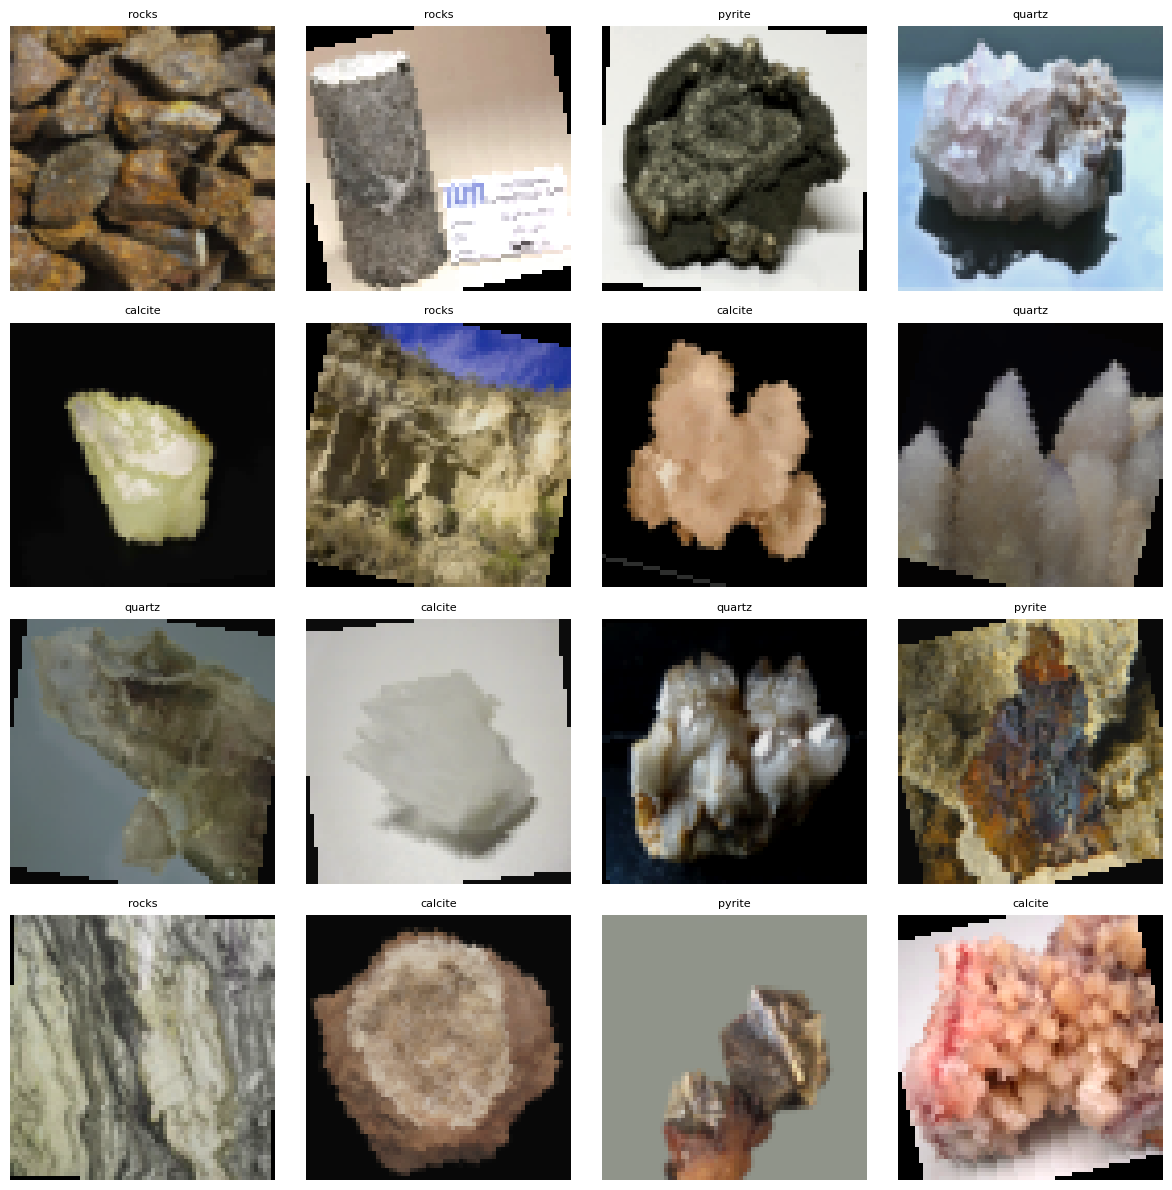

In [4]:
# Muestra aleatoria de imágenes del dataset
visualize_dataset_samples(train_loader.dataset.dataset, class_names, n_samples=16)

In [5]:
# Entrenar o cargar CustomCNN
import os

MODEL_PATH_CNN = '../models/custom_cnn.pth'
os.makedirs('../models', exist_ok=True)

if os.path.exists(MODEL_PATH_CNN):
    print("="*70)
    print("CUSTOM CNN - CARGANDO MODELO GUARDADO")
    print("="*70)
    model_cnn = CustomCNN(num_classes=len(class_names))
    model_cnn.load_state_dict(torch.load(MODEL_PATH_CNN, map_location=DEVICE))
    model_cnn = model_cnn.to(DEVICE)
    print(f"Modelo cargado desde: {MODEL_PATH_CNN}")
    print("Saltando entrenamiento...")
    history_cnn = None  # No hay historial si se carga
else:
    print("="*70)
    print("ENTRENAMIENTO CUSTOM CNN")
    print("="*70)
    print("Configuración óptima: 30 epochs, lr=0.001, weight_decay=1e-4")
    print("="*70)
    
    model_cnn = CustomCNN(num_classes=len(class_names))
    
    history_cnn = train_model(
        model_cnn,
        train_loader,
        val_loader,
        epochs=30,
        lr=0.001,
        weight_decay=1e-4,
        device=DEVICE
    )
    
    # Guardar modelo entrenado
    torch.save(model_cnn.state_dict(), MODEL_PATH_CNN)
    print(f"\n✓ Modelo guardado en: {MODEL_PATH_CNN}")
    
    print(f"\nResultados CustomCNN:")
    print(f"  Train Accuracy: {history_cnn['train_acc'][-1]:.2f}%")
    print(f"  Val Accuracy: {history_cnn['val_acc'][-1]:.2f}%")
    print(f"  Val Loss: {history_cnn['val_loss'][-1]:.4f}")

CUSTOM CNN - CARGANDO MODELO GUARDADO
Modelo cargado desde: ../models/custom_cnn.pth
Saltando entrenamiento...


In [6]:
# Visualización curvas de entrenamiento CustomCNN (solo si fue entrenado)
if history_cnn is not None:
    plot_training_history(history_cnn)
else:
    print("Modelo cargado de archivo, no hay historial de entrenamiento.")

Modelo cargado de archivo, no hay historial de entrenamiento.


In [7]:
# Entrenar o cargar ResNet18
MODEL_PATH_RESNET = '../models/resnet18.pth'

if os.path.exists(MODEL_PATH_RESNET):
    print("="*70)
    print("RESNET18 - CARGANDO MODELO GUARDADO")
    print("="*70)
    model_resnet = get_resnet18(num_classes=len(class_names), pretrained=False, freeze_layers=False)
    model_resnet.load_state_dict(torch.load(MODEL_PATH_RESNET, map_location=DEVICE))
    model_resnet = model_resnet.to(DEVICE)
    print(f"Modelo cargado desde: {MODEL_PATH_RESNET}")
    print("Saltando entrenamiento...")
    history_resnet = None  # No hay historial si se carga
else:
    print("="*70)
    print("ENTRENAMIENTO RESNET18 (TRANSFER LEARNING)")
    print("="*70)
    print("Configuración óptima: 15 epochs, lr=0.0005, weight_decay=1e-4")
    print("="*70)
    
    model_resnet = get_resnet18(num_classes=len(class_names), pretrained=True, freeze_layers=True)
    
    history_resnet = train_model(
        model_resnet,
        train_loader,
        val_loader,
        epochs=15,
        lr=0.0005,
        weight_decay=1e-4,
        device=DEVICE
    )
    
    # Guardar modelo entrenado
    torch.save(model_resnet.state_dict(), MODEL_PATH_RESNET)
    print(f"\n✓ Modelo guardado en: {MODEL_PATH_RESNET}")
    
    print(f"\nResultados ResNet18:")
    print(f"  Train Accuracy: {history_resnet['train_acc'][-1]:.2f}%")
    print(f"  Val Accuracy: {history_resnet['val_acc'][-1]:.2f}%")
    print(f"  Val Loss: {history_resnet['val_loss'][-1]:.4f}")

RESNET18 - CARGANDO MODELO GUARDADO


Modelo cargado desde: ../models/resnet18.pth
Saltando entrenamiento...


In [8]:
# Visualización curvas de entrenamiento ResNet18 (solo si fue entrenado)
if history_resnet is not None:
    plot_training_history(history_resnet)
else:
    print("Modelo cargado de archivo, no hay historial de entrenamiento.")

Modelo cargado de archivo, no hay historial de entrenamiento.


In [9]:
# Comparación visual de ambos modelos (solo si fueron entrenados)
if history_cnn is not None and history_resnet is not None:
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle('Comparación: CustomCNN vs ResNet18', fontsize=16, fontweight='bold')

    # CustomCNN
    ax = axes[0]
    ax.plot(history_cnn['train_acc'], label='Train Accuracy', linewidth=2)
    ax.plot(history_cnn['val_acc'], label='Val Accuracy', linewidth=2)
    ax.set_title('Custom CNN\n(epochs=30, lr=0.001)')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (%)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # ResNet18
    ax = axes[1]
    ax.plot(history_resnet['train_acc'], label='Train Accuracy', linewidth=2)
    ax.plot(history_resnet['val_acc'], label='Val Accuracy', linewidth=2)
    ax.set_title('ResNet18 (Transfer Learning)\n(epochs=15, lr=0.0005)')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (%)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("Modelos cargados de archivo, no hay historial de entrenamiento para comparar.")

Modelos cargados de archivo, no hay historial de entrenamiento para comparar.


In [10]:
# Evaluación Custom CNN en test set
print("="*70)
print("EVALUACIÓN: CUSTOM CNN")
print("="*70)
results_cnn = evaluate_model(model_cnn, test_loader, class_names, device=DEVICE)

EVALUACIÓN: CUSTOM CNN


/home/jaime/anaconda3/envs/logos/lib/python3.10/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Test Accuracy: 70.02%

Classification Report:
                          precision    recall  f1-score   support

                 calcite       0.67      0.73      0.70      1003
                  pyrite       0.68      0.69      0.68       353
                  quartz       0.76      0.66      0.71      1198
                   rocks       0.66      0.79      0.72       359
superficies_texturizadas       0.79      0.46      0.58        56

                accuracy                           0.70      2969
               macro avg       0.71      0.67      0.68      2969
            weighted avg       0.71      0.70      0.70      2969



In [11]:
# Evaluación ResNet18 en test set
print("\n" + "="*70)
print("EVALUACIÓN: RESNET18")
print("="*70)
results_resnet = evaluate_model(model_resnet, test_loader, class_names, device=DEVICE)


EVALUACIÓN: RESNET18
Test Accuracy: 80.77%

Classification Report:
                          precision    recall  f1-score   support

                 calcite       0.83      0.78      0.80      1003
                  pyrite       0.71      0.85      0.77       353
                  quartz       0.80      0.85      0.82      1198
                   rocks       0.93      0.70      0.80       359
superficies_texturizadas       0.76      0.91      0.83        56

                accuracy                           0.81      2969
               macro avg       0.81      0.82      0.81      2969
            weighted avg       0.81      0.81      0.81      2969



In [12]:
# Comparación final en test set
print("\n" + "="*70)
print("COMPARACIÓN FINAL - TEST SET")
print("="*70)
print(f"Custom CNN: {results_cnn['accuracy']:.2f}%")
print(f"ResNet18: {results_resnet['accuracy']:.2f}%")
print(f"\nDiferencia: {abs(results_resnet['accuracy'] - results_cnn['accuracy']):.2f}%")

if results_resnet['accuracy'] > results_cnn['accuracy']:
    print(f"ResNet18 supera a CustomCNN por {results_resnet['accuracy'] - results_cnn['accuracy']:.2f}%")
elif results_cnn['accuracy'] > results_resnet['accuracy']:
    print(f"CustomCNN supera a ResNet18 por {results_cnn['accuracy'] - results_resnet['accuracy']:.2f}%")
else:
    print("Ambos modelos tienen el mismo accuracy")
    
print("="*70)


COMPARACIÓN FINAL - TEST SET
Custom CNN: 70.02%
ResNet18: 80.77%

Diferencia: 10.74%
ResNet18 supera a CustomCNN por 10.74%


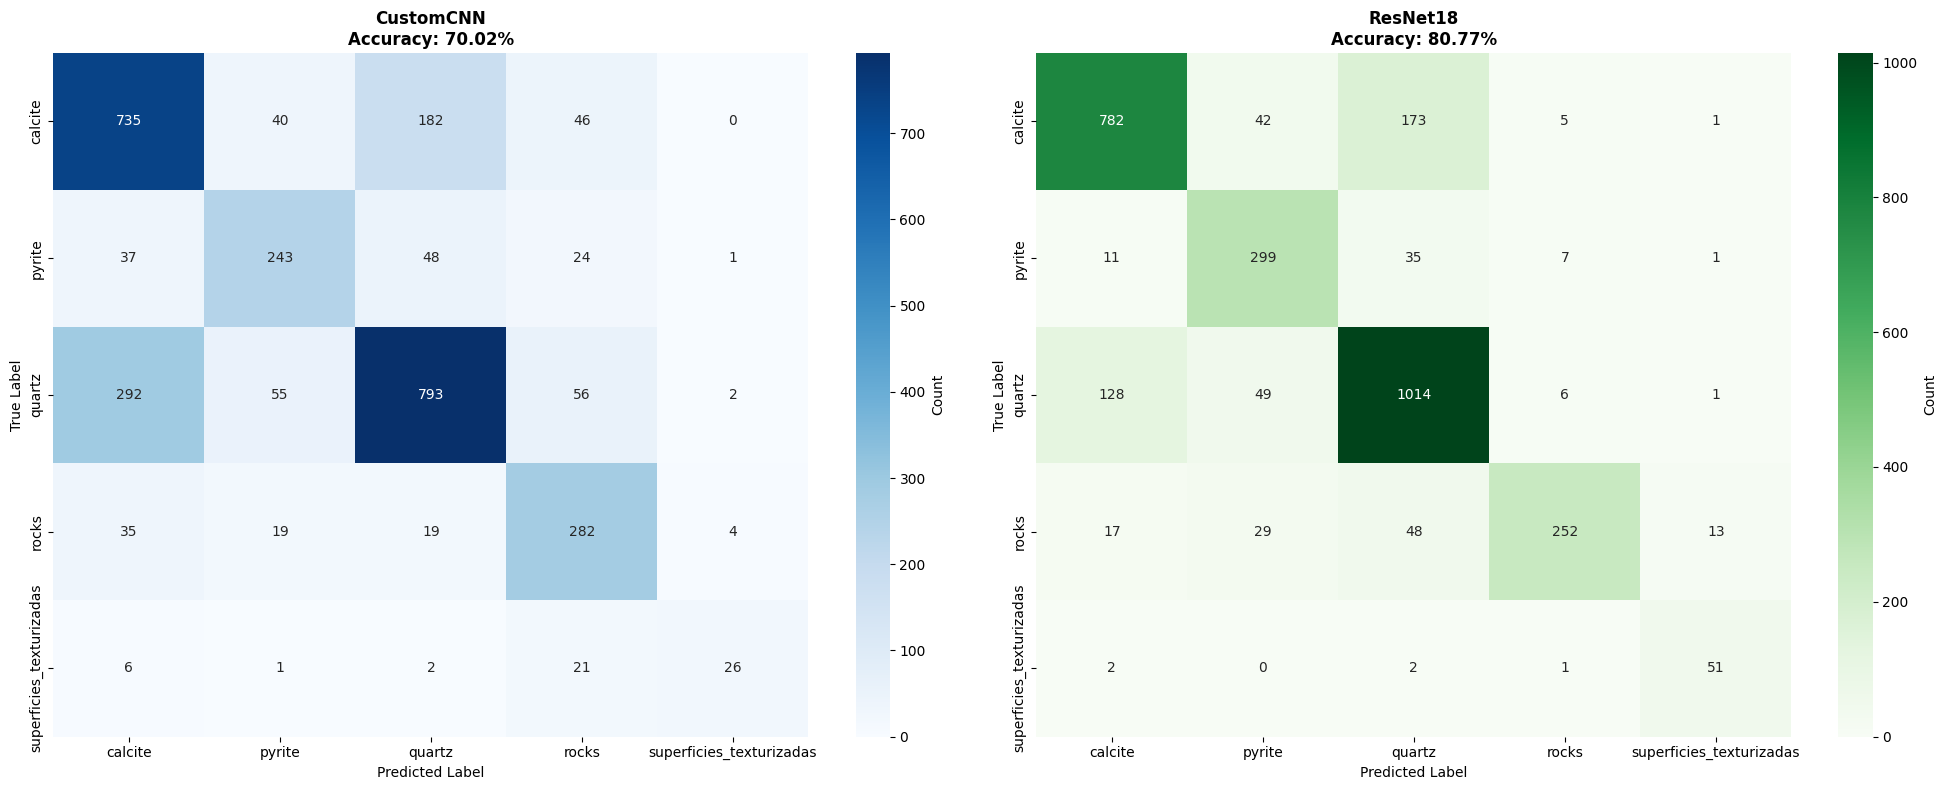

In [13]:
# Matrices de confusión de ambos modelos
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# CustomCNN
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_cnn = confusion_matrix(results_cnn['labels'], results_cnn['predictions'])
ax1 = axes[0]
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, 
            yticklabels=class_names, ax=ax1, cbar_kws={'label': 'Count'})
ax1.set_title(f'CustomCNN\nAccuracy: {results_cnn["accuracy"]:.2f}%', 
              fontsize=12, fontweight='bold')
ax1.set_ylabel('True Label', fontsize=10)
ax1.set_xlabel('Predicted Label', fontsize=10)

# ResNet18
cm_resnet = confusion_matrix(results_resnet['labels'], results_resnet['predictions'])
ax2 = axes[1]
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, 
            yticklabels=class_names, ax=ax2, cbar_kws={'label': 'Count'})
ax2.set_title(f'ResNet18\nAccuracy: {results_resnet["accuracy"]:.2f}%', 
              fontsize=12, fontweight='bold')
ax2.set_ylabel('True Label', fontsize=10)
ax2.set_xlabel('Predicted Label', fontsize=10)

plt.tight_layout()
plt.show()

In [14]:
# Predicciones: una imagen de cada clase con ambos modelos
import numpy as np

print("="*70)
print("PREDICCIONES - UNA IMAGEN POR CLASE CON AMBOS MODELOS")
print("="*70)

test_dataset = test_loader.dataset.dataset

# Buscar índices de una imagen de cada clase
class_indices = {}
for idx in range(len(test_dataset)):
    _, label = test_dataset[idx]
    class_name = class_names[label]
    if class_name not in class_indices:
        class_indices[class_name] = idx
    if len(class_indices) == len(class_names):
        break

# Realizar predicciones con ambos modelos para cada clase
all_predictions = []
for class_name in class_names:
    idx = class_indices[class_name]
    
    # Predicciones CustomCNN
    pred_cnn, true_label, image = predict_from_dataset(
        test_dataset, model_cnn, class_names, idx, device=DEVICE, top_k=3
    )
    
    # Predicciones ResNet18
    pred_resnet, _, _ = predict_from_dataset(
        test_dataset, model_resnet, class_names, idx, device=DEVICE, top_k=3
    )
    
    all_predictions.append((class_name, pred_cnn, pred_resnet, true_label, image))
    
    print(f"\n{class_name.upper()}")
    print(f"  True Label: {true_label}")
    print(f"\n  CustomCNN:")
    for i, (pred_class, prob) in enumerate(pred_cnn, 1):
        marker = "✓" if pred_class == true_label else "✗"
        print(f"    {i}. {pred_class}: {prob:.2f}% {marker}")
    print(f"\n  ResNet18:")
    for i, (pred_class, prob) in enumerate(pred_resnet, 1):
        marker = "✓" if pred_class == true_label else "✗"
        print(f"    {i}. {pred_class}: {prob:.2f}% {marker}")

print("\n" + "="*70)

PREDICCIONES - UNA IMAGEN POR CLASE CON AMBOS MODELOS

CALCITE
  True Label: calcite

  CustomCNN:
    1. quartz: 54.83% ✗
    2. calcite: 39.23% ✓
    3. pyrite: 5.89% ✗

  ResNet18:
    1. quartz: 62.77% ✗
    2. calcite: 37.12% ✓
    3. pyrite: 0.09% ✗

PYRITE
  True Label: pyrite

  CustomCNN:
    1. pyrite: 57.47% ✓
    2. quartz: 21.18% ✗
    3. calcite: 20.77% ✗

  ResNet18:
    1. pyrite: 93.48% ✓
    2. quartz: 4.32% ✗
    3. calcite: 2.06% ✗

QUARTZ
  True Label: quartz

  CustomCNN:
    1. quartz: 58.69% ✓
    2. rocks: 28.07% ✗
    3. pyrite: 11.49% ✗

  ResNet18:
    1. pyrite: 89.44% ✗
    2. quartz: 9.97% ✓
    3. calcite: 0.58% ✗

ROCKS
  True Label: rocks

  CustomCNN:
    1. rocks: 98.86% ✓
    2. pyrite: 0.61% ✗
    3. superficies_texturizadas: 0.22% ✗

  ResNet18:
    1. rocks: 92.97% ✓
    2. superficies_texturizadas: 4.84% ✗
    3. quartz: 0.87% ✗

SUPERFICIES_TEXTURIZADAS
  True Label: superficies_texturizadas

  CustomCNN:
    1. superficies_texturizadas: 69.95%

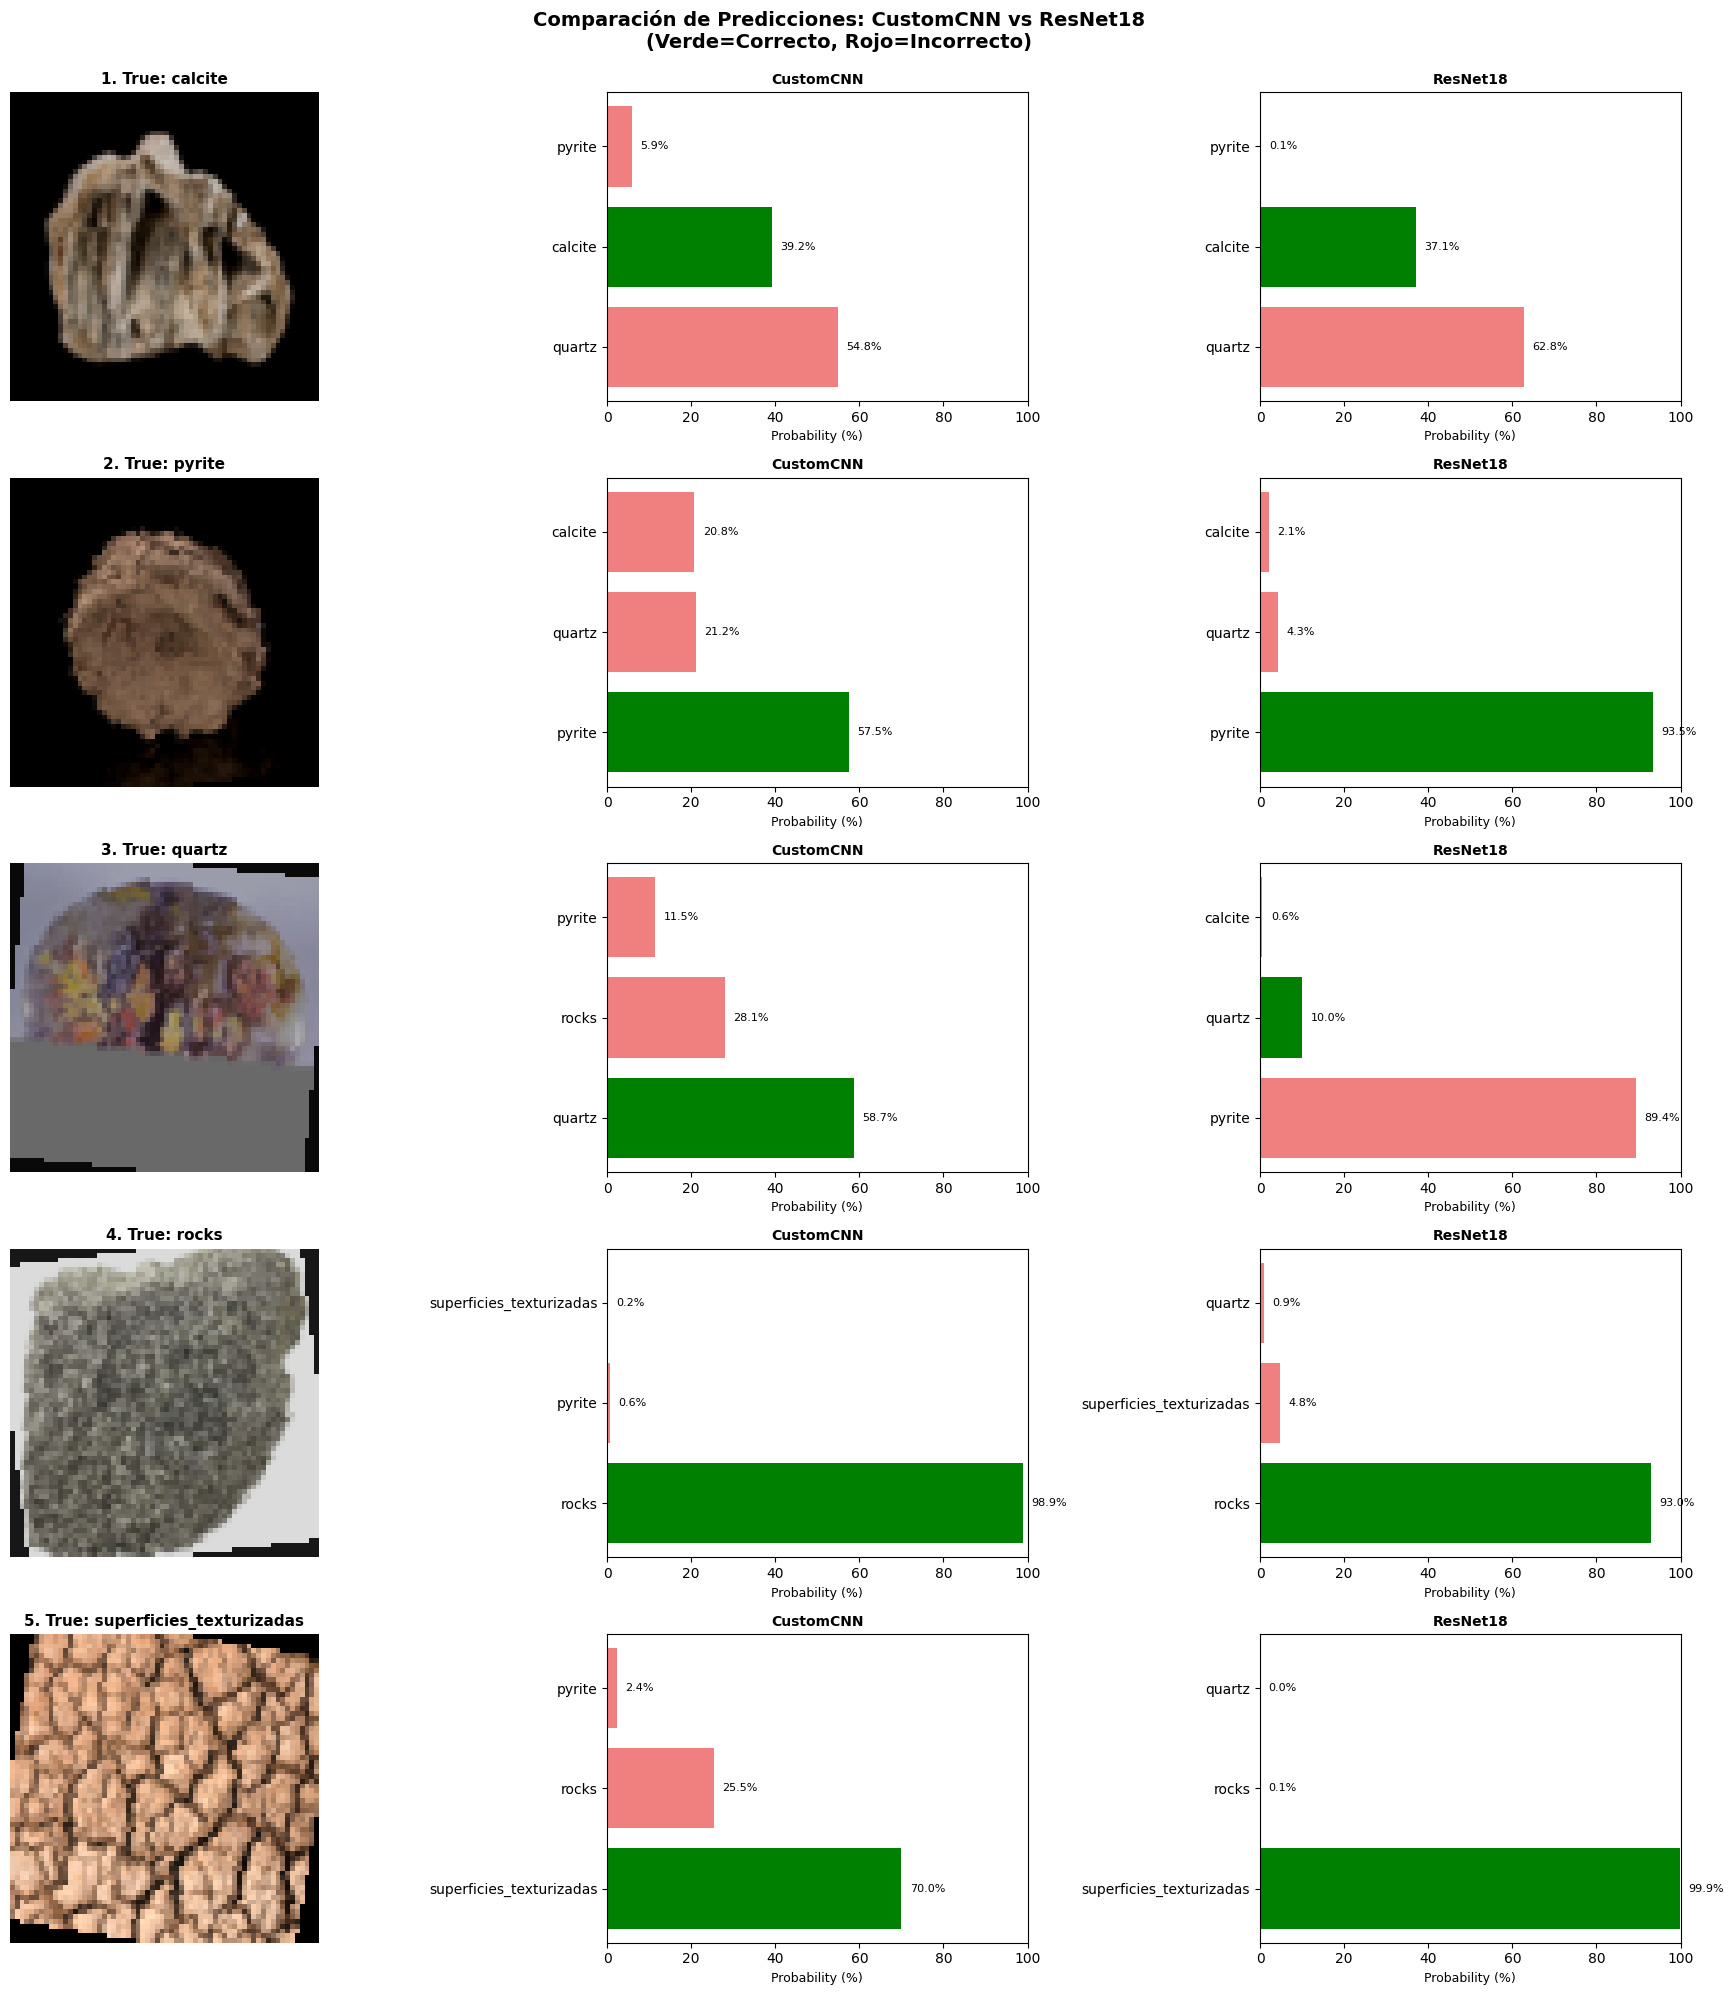

In [15]:
# Visualización comparativa: CustomCNN vs ResNet18 para las 5 clases
fig, axes = plt.subplots(5, 3, figsize=(18, 20))

for idx, (class_name, pred_cnn, pred_resnet, true_label, image_tensor) in enumerate(all_predictions):
    # Denormalizar imagen
    image = image_tensor.permute(1, 2, 0)
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    image = image * std + mean
    image = torch.clamp(image, 0, 1)
    
    # Columna 1: Imagen
    ax_img = axes[idx, 0]
    ax_img.imshow(image)
    ax_img.axis('off')
    ax_img.set_title(f'{idx+1}. True: {true_label}', fontsize=11, fontweight='bold')
    
    # Columna 2: Predicciones CustomCNN
    ax_cnn = axes[idx, 1]
    classes_cnn = [pred[0] for pred in pred_cnn]
    probs_cnn = [pred[1] for pred in pred_cnn]
    colors_cnn = ['green' if cls == true_label else 'lightcoral' for cls in classes_cnn]
    
    ax_cnn.barh(classes_cnn, probs_cnn, color=colors_cnn)
    ax_cnn.set_xlabel('Probability (%)', fontsize=9)
    ax_cnn.set_title('CustomCNN', fontsize=10, fontweight='bold')
    ax_cnn.set_xlim([0, 100])
    
    for i, (cls, prob) in enumerate(pred_cnn):
        ax_cnn.text(prob + 2, i, f'{prob:.1f}%', va='center', fontsize=8)
    
    # Columna 3: Predicciones ResNet18
    ax_resnet = axes[idx, 2]
    classes_resnet = [pred[0] for pred in pred_resnet]
    probs_resnet = [pred[1] for pred in pred_resnet]
    colors_resnet = ['green' if cls == true_label else 'lightcoral' for cls in classes_resnet]
    
    ax_resnet.barh(classes_resnet, probs_resnet, color=colors_resnet)
    ax_resnet.set_xlabel('Probability (%)', fontsize=9)
    ax_resnet.set_title('ResNet18', fontsize=10, fontweight='bold')
    ax_resnet.set_xlim([0, 100])
    
    for i, (cls, prob) in enumerate(pred_resnet):
        ax_resnet.text(prob + 2, i, f'{prob:.1f}%', va='center', fontsize=8)

fig.suptitle('Comparación de Predicciones: CustomCNN vs ResNet18\n(Verde=Correcto, Rojo=Incorrecto)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [16]:
# Resumen de modelos guardados
print("="*70)
print("MODELOS GUARDADOS")
print("="*70)
print(f"CustomCNN:")
print(f"  Path: {MODEL_PATH_CNN}")
print(f"  Test Accuracy: {results_cnn['accuracy']:.2f}%")
print(f"\nResNet18:")
print(f"  Path: {MODEL_PATH_RESNET}")
print(f"  Test Accuracy: {results_resnet['accuracy']:.2f}%")
print("\nLos modelos se guardan automáticamente después de entrenar.")
print("Si vuelves a ejecutar el notebook, se cargarán instantáneamente.")
print("="*70)

MODELOS GUARDADOS
CustomCNN:
  Path: ../models/custom_cnn.pth
  Test Accuracy: 70.02%

ResNet18:
  Path: ../models/resnet18.pth
  Test Accuracy: 80.77%

Los modelos se guardan automáticamente después de entrenar.
Si vuelves a ejecutar el notebook, se cargarán instantáneamente.
